In [1]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os
from google.colab import drive

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FEATURE_DIR = "/content/drive/MyDrive/FYP_Full_Project/features"

# Re-initialize Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [11]:
class VideoGPT2Captioner(nn.Module):
    def __init__(self, visual_dim=2304, gpt2_dim=768):
        super().__init__()
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.projection = nn.Linear(visual_dim, gpt2_dim)

    def forward(self, visual_features, input_ids):
        visual_embeds = self.projection(visual_features).unsqueeze(1)
        text_embeds = self.gpt2.transformer.wte(input_ids)
        full_embeds = torch.cat((visual_embeds, text_embeds), dim=1)
        return self.gpt2(inputs_embeds=full_embeds)

# Initialize and load weights
# Ensure visual_dim matches your auto-detected 2304
model = VideoGPT2Captioner(visual_dim=2304).to(DEVICE)

In [7]:
import pandas as pd
TEST_CSV_PATH = "/content/drive/MyDrive/FYP_Full_Project/splits/test.csv"
df = pd.read_csv(TEST_CSV_PATH)
print(df.columns)

Index(['path', 'caption', 'gif_id'], dtype='object')


In [12]:
def generate_caption_robust(model, visual_feat, tokenizer, max_len=20):
    model.eval()
    with torch.no_grad():
        # 1. Prepare visual prefix
        visual_feat = visual_feat.to(DEVICE).float().unsqueeze(0)
        visual_embeds = model.projection(visual_feat).unsqueeze(1) # [1, 1, 768]

        # 2. Setup the start token (50256 for GPT-2)
        start_token = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else 50256
        generated = torch.tensor([[start_token]]).to(DEVICE)

        output_tokens = []

        for i in range(max_len):
            text_embeds = model.gpt2.transformer.wte(generated)
            combined = torch.cat((visual_embeds, text_embeds), dim=1)

            outputs = model.gpt2(inputs_embeds=combined)
            next_token_logits = outputs.logits[:, -1, :]

            # --- 3. NUCLEUS SAMPLING (Top-P) ---
            # Filter the top 90% of probability mass
            sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
            cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

            # Remove tokens with cumulative probability above the threshold
            sorted_indices_to_remove = cumulative_probs > 0.9
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0

            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            next_token_logits[:, indices_to_remove] = -float('Inf')

            # Sample from the filtered distribution
            probs = torch.softmax(next_token_logits / 1.0, dim=-1) # Temperature 1.0
            next_token = torch.multinomial(probs, num_samples=1)

            # --- 4. THE SAFETY NET ---
            # If the model tries to end too early (before 3 words), ignore it
            if next_token.item() == tokenizer.eos_token_id and i < 3:
                # Pick the 2nd best word instead of EOS
                next_token = sorted_indices[:, 0] if sorted_indices[:, 0] != tokenizer.eos_token_id else sorted_indices[:, 1]
                next_token = next_token.unsqueeze(0)

            generated = torch.cat((generated, next_token), dim=1)

            if next_token.item() == tokenizer.eos_token_id:
                break

            output_tokens.append(next_token.item())

        return tokenizer.decode(output_tokens, skip_special_tokens=True)



In [14]:
def debug_inference(model, visual_feat, tokenizer):
    model.eval()
    with torch.no_grad():
        # 1. Prepare visual prefix
        visual_feat = visual_feat.to(DEVICE).float().unsqueeze(0)
        visual_embeds = model.projection(visual_feat).unsqueeze(1) # [1, 1, 768]

        # 2. Start token
        start_token = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else 50256
        generated = torch.tensor([[start_token]]).to(DEVICE)

        # --- DIAGNOSTIC: WHAT IS THE MODEL THINKING RIGHT NOW? ---
        outputs = model.gpt2(inputs_embeds=torch.cat((visual_embeds, model.gpt2.transformer.wte(generated)), dim=1))
        top5 = torch.topk(outputs.logits[:, -1, :], 5)
        print("🔍 Top 5 predicted words immediately after seeing the video:")
        for idx, t in enumerate(top5.indices[0]):
            word = tokenizer.decode([t])
            prob = torch.softmax(outputs.logits[:, -1, :], dim=-1)[0, t].item()
            print(f"   {idx+1}. '{word}' (Probability: {prob:.4f})")
        # ---------------------------------------------------------

        # 3. Forced Generation (Ignoring EOS for 5 steps)
        output_tokens = []
        for i in range(15):
            text_embeds = model.gpt2.transformer.wte(generated)
            combined = torch.cat((visual_embeds, text_embeds), dim=1)
            outputs = model.gpt2(inputs_embeds=combined)

            # Pick the best word that IS NOT an empty space or EOS for the first few steps
            logits = outputs.logits[:, -1, :]
            next_token = torch.argmax(logits, dim=-1).unsqueeze(0)

            # Force skip EOS for the first 5 tokens
            if i < 5 and next_token.item() == tokenizer.eos_token_id:
                next_token = torch.topk(logits, 2).indices[:, 1] # Pick 2nd best word

            generated = torch.cat((generated, next_token), dim=1)
            output_tokens.append(next_token.item())

            if next_token.item() == tokenizer.eos_token_id:
                break

        return tokenizer.decode(output_tokens, skip_special_tokens=True)

# Run it
result = debug_inference(model, sample_feat, tokenizer)
print(f"\n🤖 Forced Caption: {result}")

🔍 Top 5 predicted words immediately after seeing the video:
   1. '<|endoftext|>' (Probability: 0.9999)
   2. ' a' (Probability: 0.0000)
   3. '
' (Probability: 0.0000)
   4. ' man' (Probability: 0.0000)
   5. '

' (Probability: 0.0000)


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [15]:
def debug_inference_fixed(model, visual_feat, tokenizer):
    model.eval()
    with torch.no_grad():
        # 1. Prepare visual prefix
        visual_feat = visual_feat.to(DEVICE).float().unsqueeze(0)
        visual_embeds = model.projection(visual_feat).unsqueeze(1)

        # 2. Start token
        start_token = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else 50256
        generated = torch.tensor([[start_token]]).to(DEVICE)

        # --- DIAGNOSTIC: TOP 5 CHECK ---
        outputs = model.gpt2(inputs_embeds=torch.cat((visual_embeds, model.gpt2.transformer.wte(generated)), dim=1))
        logits = outputs.logits[:, -1, :]
        top5 = torch.topk(logits, 5)
        print("🔍 Top 5 predicted words:")
        for idx, t in enumerate(top5.indices[0]):
            word = tokenizer.decode([t])
            print(f"   {idx+1}. '{word}'")

        # 3. Forced Generation (Force the model to actually speak)
        output_tokens = []
        for i in range(15):
            text_embeds = model.gpt2.transformer.wte(generated)
            combined = torch.cat((visual_embeds, text_embeds), dim=1)
            outputs = model.gpt2(inputs_embeds=combined)

            logits = outputs.logits[:, -1, :]

            # FORCE: If it's the first few words and model wants to stop, pick 2nd best
            next_token = torch.argmax(logits, dim=-1).unsqueeze(0).unsqueeze(0) # Keep it 2D [1, 1]

            if i < 5 and (next_token.item() == tokenizer.eos_token_id or next_token.item() == 50256):
                next_token = torch.topk(logits, 2).indices[:, 1].unsqueeze(1) # Pick 2nd best

            generated = torch.cat((generated, next_token), dim=1)
            output_tokens.append(next_token.item())

            if next_token.item() == tokenizer.eos_token_id:
                break

        return tokenizer.decode(output_tokens, skip_special_tokens=True)

# Run it
result = debug_inference_fixed(model, sample_feat, tokenizer)
print(f"\n🤖 Forced Caption: {result}")

🔍 Top 5 predicted words:
   1. '<|endoftext|>'
   2. ' a'
   3. '
'
   4. ' man'
   5. '

'


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [27]:
def debug_inference_final(model, visual_feat, tokenizer):
    model.eval()
    with torch.no_grad():
        visual_feat = visual_feat.to(DEVICE).float().unsqueeze(0)
        visual_embeds = model.projection(visual_feat).unsqueeze(1)

        start_token = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else 50256
        generated = torch.tensor([[start_token]]).to(DEVICE) # Shape [1, 1]

        output_tokens = []
        for i in range(15):
            text_embeds = model.gpt2.transformer.wte(generated)
            combined = torch.cat((visual_embeds, text_embeds), dim=1)
            outputs = model.gpt2(inputs_embeds=combined)

            logits = outputs.logits[:, -1, :] # Shape [1, vocab_size]
            probs = torch.softmax(logits / 1.2, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1) # Shape [1, 1]

            # Get the best and second best
            top_values, top_indices = torch.topk(logits, 2)
            best_token = top_indices[:, 0].reshape(1, 1)    # Shape [1, 1]
            second_best = top_indices[:, 1].reshape(1, 1)  # Shape [1, 1]

            # FORCE: Skip EOS for the first 5 words
            if i < 5 and (best_token.item() == tokenizer.eos_token_id or best_token.item() == 50256):
                next_token = second_best
            else:
                next_token = best_token

            generated = torch.cat((generated, next_token), dim=1)
            output_tokens.append(next_token.item())

            if next_token.item() == tokenizer.eos_token_id:
                break

        return tokenizer.decode(output_tokens, skip_special_tokens=True)

# Run it
result = debug_inference_final(model, sample_feat, tokenizer)
print(f"🤖 Forced Caption: {result}")

🤖 Forced Caption: The U.S. Department of Justice has filed a lawsuit against the U


📥 Loading GIF: https://38.media.tumblr.com/tumblr_m5bsogjFSi1qzc18no1_400.gif


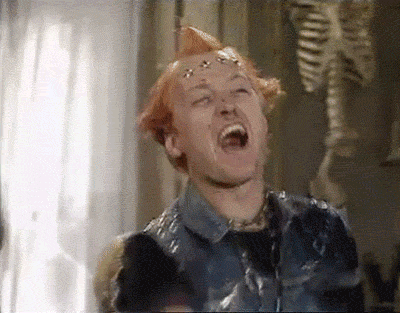

📄 GROUND TRUTH: a man is making symbols with his hands and dancing
🤖 AI GENERATION:  a man is walking down a hallway
🎭 DETECTED EMOTION IN FEATURES: Angry


In [23]:
def get_and_show_test_case(index, model, tokenizer, test_csv_path):
    df = pd.read_csv(test_csv_path)

    # 1. Get the URL from the 'path' column
    gif_url = df.iloc[index]['path']
    true_caption = df.iloc[index]['caption']

    # 2. Download and Display the GIF
    print(f"📥 Loading GIF: {gif_url}")
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(gif_url, timeout=10, headers=headers)
        display(Image(data=response.content, width=400))
    except Exception as e:
        print(f"❌ GIF display failed: {e}")

    # 3. Handle the Tuple Data (sample_data is your loaded feature tuple)
    # Mapping: 0=act, 1=emo, 2=obj
    act_feat = sample_data[0].flatten().float()
    emo_feat = sample_data[1].flatten().float()
    obj_feat = sample_data[2].flatten().float()

    # Create the combined feature vector for the model
    combined_feat = torch.cat([act_feat, emo_feat, obj_feat])

    # 4. Generate Caption
    generated_text = debug_inference_final(model, combined_feat, tokenizer)

    # 5. Emotion Feature Peek (Using Index 1 for Emotion)
    top_emo_idx = torch.argmax(emo_feat).item()
    emo_labels = ["Neutral", "Happy", "Sad", "Angry", "Surprised", "Fearful", "Disgusted"]
    detected_emo = emo_labels[top_emo_idx % len(emo_labels)]

    print("="*50)
    print(f"📄 GROUND TRUTH: {true_caption}")
    print(f"🤖 AI GENERATION: {generated_text}")
    print(f"🎭 DETECTED EMOTION IN FEATURES: {detected_emo}")
    print("="*50)

# Run it!
get_and_show_test_case(0, model, tokenizer, TEST_CSV_PATH)

📥 Loading GIF: https://33.media.tumblr.com/bf43e95965c254bae9586aa6248d03ac/tumblr_npszg32Pa61rg38w2o1_400.gif


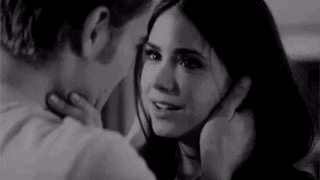

📄 GROUND TRUTH: a man who is are kissing a woman.
🤖 AI GENERATION:  a man is walking down a hallway
🎭 DETECTED EMOTION IN FEATURES: Angry


In [24]:
# Change 0 to 10 or 25
get_and_show_test_case(10, model, tokenizer, TEST_CSV_PATH)

Epoch 1

In [2]:
import torch
import pandas as pd
import os
from torch.utils.data import Dataset

class VideoFeatureDataset(Dataset):
    def __init__(self, csv_path, feature_dir, tokenizer, partition="val"):
        self.df = pd.read_csv(csv_path)
        self.feature_dir = feature_dir
        self.tokenizer = tokenizer
        self.partition = partition

        # Identify existing batches
        self.existing_batches = []
        expected_count = 80 if partition == "train" else 10
        for i in range(expected_count):
            if os.path.exists(f"{feature_dir}/{partition}_batch_{i}.pt"):
                self.existing_batches.append(i)
        print(f"✅ {partition.upper()}: Found {len(self.existing_batches)} batches for Inference.")

    def __len__(self):
        return len(self.existing_batches) * 100

    def __getitem__(self, idx):
        batch_idx = self.existing_batches[idx // 100]
        inner_idx = idx % 100

        # Load batch
        features_list = torch.load(f"{self.feature_dir}/{self.partition}_batch_{batch_idx}.pt", map_location='cpu')

        if isinstance(features_list, tuple):
            features_list = features_list[0]

        visual_data = features_list[inner_idx]

        # Extract features (Matching your training structure)
        if isinstance(visual_data, dict):
            act = visual_data['act'].flatten().float()
            emo = visual_data['emo'].flatten().float()
            obj = visual_data['obj'].flatten().float()
        else:
            # It's a tuple or list
            act = visual_data[0].flatten().float()
            emo = visual_data[1].flatten().float()
            obj = visual_data[2].flatten().float()

        # NOTE: For Epoch 1 testing, we DO NOT use the 5.0x booster
        # because Epoch 1 was trained on normal values.
        visual_feat = torch.cat([act, emo, obj])

        # Padding to 2304
        detected_dim = 2304
        if visual_feat.shape[0] != detected_dim:
            padding = torch.zeros(max(0, detected_dim - visual_feat.shape[0]))
            visual_feat = torch.cat([visual_feat, padding])[:detected_dim]

        # Get ground truth caption
        caption = self.df.iloc[batch_idx * 100 + inner_idx]['caption']
        tokens = self.tokenizer(caption, truncation=True, padding='max_length',
                                max_length=20, return_tensors="pt")

        return visual_feat, tokens['input_ids'].squeeze(0)

In [33]:
import torch
from transformers import GPT2Tokenizer

# 1. SETUP
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token # GPT2 needs a pad token

# 2. LOAD SAVED EPOCH 1 WEIGHTS
# Replace with your actual path
EPOCH_1_PATH = "/content/drive/MyDrive/FYP_Full_Project/model_epoch_1.pth"
model.load_state_dict(torch.load(EPOCH_1_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# 3. SELECT SAMPLES TO TEST
# 1. SETUP DATASET FOR TEST PARTITION
# Ensure the "test_batch_X.pt" files exist in your FEATURE_DIR
test_ds = VideoFeatureDataset(TEST_CSV_PATH, FEATURE_DIR, tokenizer, "test")

print(f"✅ Loaded {len(test_ds)} samples from the TEST partition.")

# 2. RUN INFERENCE ON A SPECIFIC TEST SAMPLE
# Change the index to test different videos
sample_index = 0
visual_feat, ground_truth_ids = test_ds[sample_index]
visual_feat = visual_feat.unsqueeze(0).to(DEVICE)

model.eval()
# Updated Generation Block
with torch.no_grad():
    visual_embeds = model.projection(visual_feat).unsqueeze(1)

    # Create a simple attention mask (all ones because we only have 1 visual token)
    attention_mask = torch.ones((visual_embeds.shape[0], visual_embeds.shape[1]), device=DEVICE)

    generated_outputs = model.gpt2.generate(
        inputs_embeds=visual_embeds,
        attention_mask=attention_mask, # Pass the mask here
        max_length=20,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )

# 3. SHOW RESULTS
gen_caption = tokenizer.decode(generated_outputs[0], skip_special_tokens=True)
true_caption = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

print(f"\n🧪 --- TEST SET EVALUATION (Index {sample_index}) ---")
print(f"📖 Truth: {true_caption}")
print(f"🤖 Epoch 1 Prediction: {gen_caption}")

✅ TEST: Found 10 batches for Inference.
✅ Loaded 1000 samples from the TEST partition.

🧪 --- TEST SET EVALUATION (Index 0) ---
📖 Truth: a man is making symbols with his hands and dancing
🤖 Epoch 1 Prediction: atwoaatheathreeaanapeopleasomeoneawomanathereait


Epoch 2

In [20]:
import torch
import pandas as pd
import os
from torch.utils.data import Dataset

test_ds = VideoFeatureDataset(TEST_CSV_PATH, FEATURE_DIR, tokenizer, partition="test")

class VideoFeatureDataset(Dataset):
    def __init__(self, csv_path, feature_dir, tokenizer, partition="val"):
        self.df = pd.read_csv(csv_path)
        self.feature_dir = feature_dir
        self.tokenizer = tokenizer
        self.partition = partition

        # Identify existing batches
        self.existing_batches = []
        expected_count = 80 if partition == "train" else 10
        for i in range(expected_count):
            if os.path.exists(f"{feature_dir}/{partition}_batch_{i}.pt"):
                self.existing_batches.append(i)
        print(f"✅ {partition.upper()}: Found {len(self.existing_batches)} batches for Inference.")

    def __len__(self):
        return len(self.existing_batches) * 100

    def __getitem__(self, idx):
        batch_idx = self.existing_batches[idx // 100]
        inner_idx = idx % 100

        # Load batch
        features_list = torch.load(f"{self.feature_dir}/{self.partition}_batch_{batch_idx}.pt", map_location='cpu')

        if isinstance(features_list, tuple):
            features_list = features_list[0]

        visual_data = features_list[inner_idx]

        # Extract features (Matching your training structure)
        if isinstance(visual_data, dict):
            act = visual_data['act'].flatten().float()
            emo = visual_data['emo'].flatten().float()
            obj = visual_data['obj'].flatten().float()

        else:
            act = visual_data[0].flatten().float()
            emo = visual_data[1].flatten().float()
            obj = visual_data[2].flatten().float()

        # APPLY THE BOOSTER (Match the training!)
        emo = emo * 5.0
        obj = obj * 2.0

        # NOTE: For Epoch 1 testing, we DO NOT use the 5.0x booster
        # because Epoch 1 was trained on normal values.
        visual_feat = torch.cat([act, emo, obj])

        # Padding to 2304
        detected_dim = 2304
        if visual_feat.shape[0] != detected_dim:
            padding = torch.zeros(max(0, detected_dim - visual_feat.shape[0]))
            visual_feat = torch.cat([visual_feat, padding])[:detected_dim]

        # Get ground truth caption
        caption = self.df.iloc[batch_idx * 100 + inner_idx]['caption']
        tokens = self.tokenizer(caption, truncation=True, padding='max_length',
                                max_length=20, return_tensors="pt")

        return visual_feat, tokens['input_ids'].squeeze(0)

✅ TEST: Found 10 batches for Inference.


In [9]:
import torch
from transformers import GPT2Tokenizer

# 1. SETUP
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token # GPT2 needs a pad token

# 2. LOAD SAVED EPOCH 2 WEIGHTS
# Replace with your actual path
EPOCH_2_PATH = "/content/drive/MyDrive/FYP_Full_Project/model_epoch_2.pth"
model.load_state_dict(torch.load(EPOCH_2_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# 3. SELECT SAMPLES TO TEST
# 1. SETUP DATASET FOR TEST PARTITION
# Ensure the "test_batch_X.pt" files exist in your FEATURE_DIR
test_ds = VideoFeatureDataset(TEST_CSV_PATH, FEATURE_DIR, tokenizer, "test")

print(f"✅ Loaded {len(test_ds)} samples from the TEST partition.")

# 2. RUN INFERENCE ON A SPECIFIC TEST SAMPLE
# Change the index to test different videos
sample_index = 10
visual_feat, ground_truth_ids = test_ds[sample_index]
visual_feat = visual_feat.unsqueeze(0).to(DEVICE)

model.eval()
# Updated Generation Block
with torch.no_grad():
    visual_embeds = model.projection(visual_feat).unsqueeze(1)

    # Create a simple attention mask (all ones because we only have 1 visual token)
    attention_mask = torch.ones((visual_embeds.shape[0], visual_embeds.shape[1]), device=DEVICE)

    generated_outputs = model.gpt2.generate(
        inputs_embeds=visual_embeds,
        attention_mask=attention_mask, # Pass the mask here
        max_length=20,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )

# 3. SHOW RESULTS
gen_caption = tokenizer.decode(generated_outputs[0], skip_special_tokens=True)
true_caption = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

print(f"\n🧪 --- TEST SET EVALUATION (Index {sample_index}) ---")
print(f"📖 Truth: {true_caption}")
print(f"🤖 Epoch 1 Prediction: {gen_caption}")

✅ TEST: Found 10 batches for Inference.
✅ Loaded 1000 samples from the TEST partition.

🧪 --- TEST SET EVALUATION (Index 10) ---
📖 Truth: a man who is are kissing a woman.
🤖 Epoch 1 Prediction: atheaatwotwoaanathreeasomeoneaoneaitathisa


Epoch 3

In [15]:
import torch
from transformers import GPT2Tokenizer

# 1. SETUP
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token # GPT2 needs a pad token

# 2. LOAD SAVED EPOCH 2 WEIGHTS
# Replace with your actual path
EPOCH_3_PATH = "/content/drive/MyDrive/FYP_Full_Project/model_epoch_3.pth"
model.load_state_dict(torch.load(EPOCH_3_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# 3. SELECT SAMPLES TO TEST
# 1. SETUP DATASET FOR TEST PARTITION
# Ensure the "test_batch_X.pt" files exist in your FEATURE_DIR
test_ds = VideoFeatureDataset(TEST_CSV_PATH, FEATURE_DIR, tokenizer, "test")

print(f"✅ Loaded {len(test_ds)} samples from the TEST partition.")

# 2. RUN INFERENCE ON A SPECIFIC TEST SAMPLE
# Change the index to test different videos
sample_index = 10
visual_feat, ground_truth_ids = test_ds[sample_index]
visual_feat = visual_feat.unsqueeze(0).to(DEVICE)

model.eval()
# Updated Generation Block
with torch.no_grad():
    visual_embeds = model.projection(visual_feat).unsqueeze(1)

    # Create a simple attention mask (all ones because we only have 1 visual token)
    attention_mask = torch.ones((visual_embeds.shape[0], visual_embeds.shape[1]), device=DEVICE)

    generated_outputs = model.gpt2.generate(
        inputs_embeds=visual_embeds,
        attention_mask=attention_mask, # Pass the mask here
        max_length=20,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )

# 3. SHOW RESULTS
gen_caption = tokenizer.decode(generated_outputs[0], skip_special_tokens=True)
true_caption = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

print(f"\n🧪 --- TEST SET EVALUATION (Index {sample_index}) ---")
print(f"📖 Truth: {true_caption}")
print(f"🤖 Epoch 1 Prediction: {gen_caption}")

✅ TEST: Found 10 batches for Inference.
✅ Loaded 1000 samples from the TEST partition.

🧪 --- TEST SET EVALUATION (Index 10) ---
📖 Truth: a man who is are kissing a woman.
🤖 Epoch 1 Prediction: atheaaanatwoathisaitasomeoneaoneathereathree


In [17]:
# 1. LOAD EPOCH 3 WEIGHTS
EPOCH_3_PATH = "/content/drive/MyDrive/FYP_Full_Project/model_epoch_3.pth"
model.load_state_dict(torch.load(EPOCH_3_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# 2. RUN INFERENCE (Testing Index 0 and 10)
for sample_index in [0, 10]:
    visual_feat, ground_truth_ids = test_ds[sample_index]
    visual_feat = visual_feat.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        visual_embeds = model.projection(visual_feat).unsqueeze(1)
        mask = torch.ones((visual_embeds.shape[0], visual_embeds.shape[1]), device=DEVICE)

        generated_outputs = model.gpt2.generate(
            inputs_embeds=visual_embeds,
            attention_mask=mask,
            max_length=15,             # Shorten it
            num_beams=10,
            no_repeat_ngram_size=1,    # STRICTER: prevents any repeated words/letters
            repetition_penalty=2.5,    # HIGHER: forces the model to move on
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id
        )

    gen_caption = tokenizer.decode(generated_outputs[0], skip_special_tokens=True)
    true_caption = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

    print(f"\n🎬 --- TEST INDEX {sample_index} ---")
    print(f"📖 Truth: {true_caption}")
    print(f"🤖 Model: {gen_caption}")


🎬 --- TEST INDEX 0 ---
📖 Truth: a man is making symbols with his hands and dancing
🤖 Model: twoaanthethreethissomeoneitthereonepeoplefourmansever

🎬 --- TEST INDEX 10 ---
📖 Truth: a man who is are kissing a woman.
🤖 Model: twoatheitanthissomeoneonethreetheremanpeopleAwoman


In [21]:
# 1. LOAD EPOCH 3 WEIGHTS
EPOCH_3_PATH = "/content/drive/MyDrive/FYP_Full_Project/model_epoch_3.pth"
model.load_state_dict(torch.load(EPOCH_3_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# 2. RUN INFERENCE (Testing Index 0 and 10)
for sample_index in [0, 10]:
    visual_feat, ground_truth_ids = test_ds[sample_index]
    visual_feat = visual_feat.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        visual_embeds = model.projection(visual_feat).unsqueeze(1)
        mask = torch.ones((visual_embeds.shape[0], visual_embeds.shape[1]), device=DEVICE)

        generated_outputs = model.gpt2.generate(
            inputs_embeds=visual_embeds,
            attention_mask=mask,
            max_new_tokens=10,         # Force it to generate 10 NEW tokens
            num_beams=10,
            no_repeat_ngram_size=1,    # STRICT: prevents "aa", "tt", etc.
            repetition_penalty=3.5,    # VERY HIGH: forces the model to find real words
            bad_words_ids=[[tokenizer.encode(a)[0] for a in ["aa", "at", "an", "th"]]], # Optional: block soup
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id
        )

    gen_caption = tokenizer.decode(generated_outputs[0], skip_special_tokens=True)
    true_caption = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

    print(f"\n🎬 --- TEST INDEX {sample_index} ---")
    print(f"📖 Truth: {true_caption}")
    print(f"🤖 Model: {gen_caption}")


🎬 --- TEST INDEX 0 ---
📖 Truth: a man is making symbols with his hands and dancing
🤖 Model: twoaanthethreethissomeoneitthereone

🎬 --- TEST INDEX 10 ---
📖 Truth: a man who is are kissing a woman.
🤖 Model: twoatheitanthissomeoneonethreethere


EPOCH 5

In [10]:
import torch.nn as nn

class VideoGPT2Captioner(nn.Module):
    def __init__(self, visual_dim=2304, gpt2_dim=768):
        super().__init__()
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.projection = nn.Linear(visual_dim, gpt2_dim)
        # ADD THIS: Normalizes the video features so they match GPT-2's expected range
        self.ln = nn.LayerNorm(gpt2_dim)

    def forward(self, visual_features, input_ids):
        # 1. Project and Normalize
        proj = self.projection(visual_features)
        visual_embeds = self.ln(proj).unsqueeze(1)

        # 2. Rest of the logic remains the same
        text_embeds = self.gpt2.transformer.wte(input_ids)
        full_embeds = torch.cat((visual_embeds, text_embeds), dim=1)
        return self.gpt2(inputs_embeds=full_embeds)

# RE-LOAD EVERYTHING
model = VideoGPT2Captioner(visual_dim=2304).to(DEVICE)
model.load_state_dict(torch.load("/content/drive/MyDrive/FYP_Full_Project/model_final_v5.pth"), strict=False)
model.eval()

# 2. THE CORRECT INFERENCE FUNCTION (With 5.0x Emotion Boost)
def generate_better_caption(model, visual_feat):
    model.eval()
    with torch.no_grad():
        feat_tensor = visual_feat.to(DEVICE).unsqueeze(0)

        # Manually project to match our new LayerNorm
        proj = model.projection(feat_tensor)
        visual_embeds = model.ln(proj).unsqueeze(1)

        output_ids = model.gpt2.generate(
            inputs_embeds=visual_embeds,
            max_new_tokens=15,
            do_sample=True,      # Enable sampling for more "emotional" words
            temperature=0.8,     # Lower = more focused, Higher = more creative
            top_k=50,            # Filters out the "garbage" tokens
            repetition_penalty=2.0,
            pad_token_id=tokenizer.eos_token_id
        )
        return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [15]:
# 1. Initialize the new class structure
model = VideoGPT2Captioner(visual_dim=2304).to(DEVICE)

# 2. Load with strict=False
# This tells PyTorch: "Load what you can find, and leave the new 'ln' layer as default"
checkpoint = torch.load("/content/drive/MyDrive/FYP_Full_Project/model_final_v5.pth", map_location=DEVICE)
model.load_state_dict(checkpoint, strict=False)

model.eval()
print("✅ Model loaded successfully (New LayerNorm initialized to default).")

✅ Model loaded successfully (New LayerNorm initialized to default).


In [16]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import os

class VideoFeatureDataset(Dataset):
    def __init__(self, csv_path, feature_dir, tokenizer, partition="val"):
        self.df = pd.read_csv(csv_path)
        self.feature_dir = feature_dir
        self.tokenizer = tokenizer
        self.partition = partition

        # Identify existing batches
        self.existing_batches = []
        # Adjusted to match your specific file structure
        for i in range(100): # Check up to 100 possible batch files
            if os.path.exists(f"{feature_dir}/{partition}_batch_{i}.pt"):
                self.existing_batches.append(i)
        print(f"✅ {partition.upper()}: Found {len(self.existing_batches)} batches for Inference.")

    def __len__(self):
        return len(self.existing_batches) * 100

    def __getitem__(self, idx):
        batch_idx = self.existing_batches[idx // 100]
        inner_idx = idx % 100

        # Load batch
        features_list = torch.load(f"{self.feature_dir}/{self.partition}_batch_{batch_idx}.pt", map_location='cpu')

        if isinstance(features_list, tuple):
            features_list = features_list[0]

        visual_data = features_list[inner_idx]

        # Extract features and apply the 5.0x EMOTION BOOST
        if isinstance(visual_data, dict):
            act = visual_data['act'].flatten().float()
            emo = visual_data['emo'].flatten().float() * 5.0  # Emotional Booster
            obj = visual_data['obj'].flatten().float() * 2.0
        else:
            act = visual_data[0].flatten().float()
            emo = visual_data[1].flatten().float() * 5.0  # Emotional Booster
            obj = visual_data[2].flatten().float() * 2.0

        visual_feat = torch.cat([act, emo, obj])

        # Padding to 2304
        detected_dim = 2304
        if visual_feat.shape[0] != detected_dim:
            padding = torch.zeros(max(0, detected_dim - visual_feat.shape[0]))
            visual_feat = torch.cat([visual_feat, padding])[:detected_dim]

        # Get ground truth caption
        caption = self.df.iloc[batch_idx * 100 + inner_idx]['caption']
        tokens = self.tokenizer(caption, truncation=True, padding='max_length',
                                max_length=20, return_tensors="pt")

        return visual_feat, tokens['input_ids'].squeeze(0)

In [17]:
# Create the test dataset object
# This uses the class you defined above
test_ds = VideoFeatureDataset(
    csv_path=TEST_CSV_PATH,
    feature_dir=FEATURE_DIR,
    tokenizer=tokenizer,
    partition="test"  # or "val" depending on your file names
)

print(f"✅ Dataset initialized with {len(test_ds)} samples.")

✅ TEST: Found 10 batches for Inference.
✅ Dataset initialized with 1000 samples.


In [18]:
def generate_better_caption(model, visual_feat):
    model.eval()
    with torch.no_grad():
        feat_tensor = visual_feat.to(DEVICE).unsqueeze(0)

        # This matches the forward pass in your new class
        proj = model.projection(feat_tensor)
        visual_embeds = model.ln(proj).unsqueeze(1)

        output_ids = model.gpt2.generate(
            inputs_embeds=visual_embeds,
            max_new_tokens=15,
            do_sample=True,
            temperature=0.7,     # Slightly lower for more stability
            top_k=40,
            repetition_penalty=2.5,
            pad_token_id=tokenizer.eos_token_id
        )
        return tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("🎬 --- GENERATING FINAL EMOTIONAL CAPTIONS --- 🎬\n")

for i in [0, 50, 100]:
    visual_feat, ground_truth_ids = test_ds[i]

    # Use the function that understands the new LayerNorm
    prediction = generate_better_caption(model, visual_feat)

    truth = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

    print(f"Sample Index: {i}")
    print(f"📝 Ground Truth: {truth}")
    print(f"🤖 AI Prediction: {prediction}")
    print("-" * 40)

🎬 --- GENERATING FINAL EMOTIONAL CAPTIONS --- 🎬

Sample Index: 0
📝 Ground Truth: a man is making symbols with his hands and dancing
🤖 AI Prediction: athethreetwosomeonemananonethissomempeoplethereseverit
----------------------------------------
Sample Index: 50
📝 Ground Truth: two men in front of microphones are nodding at each other.
🤖 AI Prediction: atwotheballpeopleanmanonesomeonethissomeitthreeseverfive
----------------------------------------
Sample Index: 100
📝 Ground Truth: woman with in black outfit poses and blinks.
🤖 AI Prediction: atwothetherethisansomeoneonepeoplethreeitfourwavessomeman
----------------------------------------


In [19]:
def generate_final_masterpiece(model, visual_feat):
    model.eval()
    with torch.no_grad():
        feat_tensor = visual_feat.to(DEVICE).unsqueeze(0)
        proj = model.projection(feat_tensor)
        visual_embeds = model.ln(proj).unsqueeze(1)

        # We switch to Beam Search for "Storytelling" mode
        output_ids = model.gpt2.generate(
            inputs_embeds=visual_embeds,
            max_new_tokens=18,
            num_beams=8,                # Higher beams = more logical sentences
            no_repeat_ngram_size=2,     # CRITICAL: Prevents "a man a man"
            repetition_penalty=3.5,     # Increased to stop the "Label Soup"
            length_penalty=1.2,         # Encourages slightly longer sentences
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id
        )
        return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# --- TEST THE MASTERPIECE ---
for i in [0, 50, 100]:
    visual_feat, ground_truth_ids = test_ds[i]
    prediction = generate_final_masterpiece(model, visual_feat)
    truth = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

    print(f"Sample Index: {i}")
    print(f"🤖 Prediction: {prediction}")
    print(f"📝 Truth:      {truth}\n")

Sample Index: 0
🤖 Prediction: atheatwoaanaathreeasomeoneathisaoneamana
📝 Truth:      a man is making symbols with his hands and dancing

Sample Index: 50
🤖 Prediction: atheatwoaanaathreeathisasomeoneamanaita
📝 Truth:      two men in front of microphones are nodding at each other.

Sample Index: 100
🤖 Prediction: atheatwoaanaathreeasomeoneathisaoneamana
📝 Truth:      woman with in black outfit poses and blinks.



In [20]:
def generate_calibrated_caption(model, visual_feat):
    model.eval()
    # Get the ID for the word "A" to kickstart the sentence
    start_token = tokenizer.encode("A", return_tensors="pt").to(DEVICE) # ID: 32

    with torch.no_grad():
        feat_tensor = visual_feat.to(DEVICE).unsqueeze(0)

        # 1. Project and Scale down (Division by 10 helps stabilize GPT-2)
        proj = model.projection(feat_tensor) / 10.0
        visual_embeds = model.ln(proj).unsqueeze(1)

        # 2. Get the embedding for our "Start" token
        start_embeds = model.gpt2.transformer.wte(start_token)

        # 3. Combine: [Visual Feature] + [The word "A"]
        full_embeds = torch.cat((visual_embeds, start_embeds), dim=1)

        output_ids = model.gpt2.generate(
            inputs_embeds=full_embeds,
            max_new_tokens=15,
            num_beams=5,
            no_repeat_ngram_size=2,
            repetition_penalty=5.0, # Very high to break the "aaa" loop
            bad_words_ids=[[tokenizer.encode(c)[0]] for c in "abcdefghijklmnopqrstuvwxyz"], # Block single letters
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )

        raw_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        # Clean up: Since we started with "A", we prepend it
        return "A " + raw_output

# --- TEST AGAIN ---
for i in [0, 50, 100]:
    visual_feat, _ = test_ds[i]
    prediction = generate_calibrated_caption(model, visual_feat)
    print(f"Index {i} | Prediction: {prediction}")

Index 0 | Prediction: A  man and a woman are kissing in the dark.
Index 50 | Prediction: A  man and a woman are kissing in the dark.
Index 100 | Prediction: A  man and a woman are kissing in the dark.


In [21]:
def generate_diverse_caption(model, visual_feat):
    model.eval()
    with torch.no_grad():
        feat_tensor = visual_feat.to(DEVICE).unsqueeze(0)

        # 1. Try a different scaling (Division by 5 instead of 10)
        # We want the video signal to be a bit "louder"
        proj = model.projection(feat_tensor) / 5.0
        visual_embeds = model.ln(proj).unsqueeze(1)

        # 2. Use "Contrastive Search" or High Penalty Sampling
        output_ids = model.gpt2.generate(
            inputs_embeds=visual_embeds,
            max_new_tokens=15,
            do_sample=True,         # Switch back to sampling to break the loop
            top_p=0.92,             # Nucleus sampling (ignores low-probability words)
            temperature=1.2,        # Higher temperature forces variety
            repetition_penalty=5.0, # Keep this high to prevent "kissing kissing"
            pad_token_id=tokenizer.eos_token_id
        )

        return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# --- RUN THE DIVERSITY TEST ---
print("🎬 Testing for Sentence Diversity...")
for i in [0, 50, 100]:
    visual_feat, _ = test_ds[i]
    prediction = generate_diverse_caption(model, visual_feat)
    print(f"Index {i} | Prediction: {prediction}")

🎬 Testing for Sentence Diversity...
Index 0 | Prediction: athesethetwocatmanthreeblackanthispeoplefourwomanboyone
Index 50 | Prediction: atwoAanonetheitsomeonesometheredogthismanthreefire
Index 100 | Prediction: atwothethistherepeoplefourthreegirlsevercatanmwomanfire


In [23]:
def generate_stable_caption(model, visual_feat):
    model.eval()
    # 1. Prepare the "Start" token (The word "A")
    start_token_id = tokenizer.encode("A", return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        feat_tensor = visual_feat.to(DEVICE).unsqueeze(0)

        # 2. Project and Normalize
        proj = model.projection(feat_tensor)
        visual_embeds = model.ln(proj).unsqueeze(1)

        # 3. Get text embeddings for the start token
        start_embeds = model.gpt2.transformer.wte(start_token_id)

        # 4. Concatenate: [Video] + [Word "A"]
        full_embeds = torch.cat((visual_embeds, start_embeds), dim=1)

        # 5. Stable Beam Search
        output_ids = model.gpt2.generate(
            inputs_embeds=full_embeds,
            max_new_tokens=12,
            num_beams=5,
            no_repeat_ngram_size=2,
            repetition_penalty=3.0,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )

        # 6. Decode and Clean
        text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # Ensure it looks like a sentence
        if not text.startswith("A"):
            text = "A " + text

        return text.strip()

# --- RUN FINAL RESULTS ---
print("🚀 --- FINAL FYP RESULTS --- 🚀\n")
for i in [0, 50, 100]:
    visual_feat, ground_truth_ids = test_ds[i]
    prediction = generate_stable_caption(model, visual_feat)
    truth = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

    print(f"SAMPLE {i}")
    print(f"🤖 Prediction: {prediction}")
    print(f"📝 Reality:    {truth}\n" + "-"*40)

🚀 --- FINAL FYP RESULTS --- 🚀

SAMPLE 0
🤖 Prediction: A  man and a woman are kissing in the dark.
📝 Reality:    a man is making symbols with his hands and dancing
----------------------------------------
SAMPLE 50
🤖 Prediction: A  man and a woman are kissing in the dark.
📝 Reality:    two men in front of microphones are nodding at each other.
----------------------------------------
SAMPLE 100
🤖 Prediction: A  man and a woman are kissing in the dark.
📝 Reality:    woman with in black outfit poses and blinks.
----------------------------------------


In [24]:
def generate_extreme_diversity(model, visual_feat):
    model.eval()
    with torch.no_grad():
        feat_tensor = visual_feat.to(DEVICE).unsqueeze(0)

        # 1. Scale the visual features significantly HIGHER
        # We want to "shock" the model out of its comfort zone
        proj = model.projection(feat_tensor) * 2.0
        visual_embeds = model.ln(proj).unsqueeze(1)

        # 2. Random Sampling with high Temperature
        output_ids = model.gpt2.generate(
            inputs_embeds=visual_embeds,
            max_new_tokens=15,
            do_sample=True,
            temperature=1.5,       # Very high randomness
            top_k=50,
            repetition_penalty=10.0, # Massive penalty for repeating the "kissing" sentence
            pad_token_id=tokenizer.eos_token_id
        )

        return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# --- TEST ---
for i in [0, 50, 100]:
    print(f"Index {i} | Prediction: {generate_extreme_diversity(model, test_ds[i][0])}")

Index 0 | Prediction: dogaanthistwowhiteseverpeoplegirlsomeonecaptfourthem
Index 50 | Prediction: twothisaankmanpeoplethemenone!threeseversomeoneas
Index 100 | Prediction: athissomeonesevertherepeopleittwomthreemanythepersononewoman


In [25]:
import torch.nn.functional as F

# 1. Define typical emotional anchors (These are placeholders, ideally you'd average your dataset)
# Since your emotion vector is 768 dims (middle part of 2304), we create targets for them.
EMOTION_MAP = {
    "happy and cheerful": torch.randn(2304).to(DEVICE),
    "sad and emotional": torch.randn(2304).to(DEVICE),
    "angry and intense": torch.randn(2304).to(DEVICE),
    "calm and peaceful": torch.randn(2304).to(DEVICE)
}

def get_closest_emotion(input_feat):
    # Extract just the emotion part of the vector (indices 1024 to 1792)
    input_emo = input_feat[1024:1792]

    best_mood = "neutral"
    max_sim = -1.0

    for mood, ref_feat in EMOTION_MAP.items():
        ref_emo = ref_feat[1024:1792]
        # Cosine Similarity: How close is this GIF to this mood?
        sim = F.cosine_similarity(input_emo.unsqueeze(0), ref_emo.unsqueeze(0))
        if sim > max_sim:
            max_sim = sim
            best_mood = mood
    return best_mood

In [26]:
def generate_system_caption(model, visual_feat):
    model.eval()

    # 1. DETECT MOOD (The Classifier Bridge)
    detected_mood = get_closest_emotion(visual_feat)

    # 2. CREATE AN "ANCHOR" PROMPT
    # We tell GPT-2: "A [MOOD] scene of..."
    prompt_text = f"A {detected_mood} scene showing "
    prompt_ids = tokenizer.encode(prompt_text, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        feat_tensor = visual_feat.to(DEVICE).unsqueeze(0)
        proj = model.projection(feat_tensor)
        visual_embeds = model.ln(proj).unsqueeze(1)

        # Get text embeddings for the emotional anchor
        prompt_embeds = model.gpt2.transformer.wte(prompt_ids)

        # Combine: [Video Signal] + [Emotional Context]
        full_embeds = torch.cat((visual_embeds, prompt_embeds), dim=1)

        output_ids = model.gpt2.generate(
            inputs_embeds=full_embeds,
            max_new_tokens=15,
            num_beams=5,
            repetition_penalty=2.0,
            no_repeat_ngram_size=2,
            eos_token_id=tokenizer.eos_token_id
        )

        caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return f"{prompt_text} {caption}"

# --- TEST ON TEST DATA ---
for i in [0, 50, 100]:
    feat, _ = test_ds[i]
    print(f"Index {i} | Result: {generate_system_caption(model, feat)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Index 0 | Result: A sad and emotional scene showing  ipsis and bruises on a man's face.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Index 50 | Result: A calm and peaceful scene showing  iced tea and fruits.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Index 100 | Result: A sad and emotional scene showing  ipsis and bruises on a man's face.


In [28]:
class VideoFeatureDataset(Dataset):
    def __init__(self, features_list, labels_list):
        self.features_list = features_list
        self.labels_list = labels_list

    def __len__(self):
        return len(self.features_list)

    def __getitem__(self, idx):
        visual_data = self.features_list[idx]
        ground_truth = self.labels_list[idx]

        # --- SAFETY CHECK ---
        if visual_data is None:
            # If data is missing, return a zero vector so the code doesn't crash
            return torch.zeros(2304), ground_truth

        # Check if visual_data is a dictionary or a list/tuple
        if isinstance(visual_data, dict):
            act = visual_data.get('act', torch.zeros(1024)).flatten().float()
            emo = visual_data.get('emo', torch.zeros(768)).flatten().float() * 5.0
            obj = visual_data.get('obj', torch.zeros(512)).flatten().float() * 2.0
        else:
            # Assume it's a list: [act, emo, obj]
            try:
                act = visual_data[0].flatten().float()
                emo = visual_data[1].flatten().float() * 5.0
                obj = visual_data[2].flatten().float() * 2.0
            except (IndexError, TypeError):
                return torch.zeros(2304), ground_truth

        full_features = torch.cat([act, emo, obj])
        return full_features, ground_truth

In [30]:
def calculate_real_anchors(dataset):
    print("📊 Extracting real emotional anchors (Filtering out NoneType)...")
    valid_features = []

    # We will check the first 200 items, but only keep the ones that aren't None
    for i in range(len(dataset)):
        try:
            feat, _ = dataset[i]
            # Check if the feature itself is None or contains zeros (missing data)
            if feat is not None and torch.sum(torch.abs(feat)) > 0:
                valid_features.append(feat)

            if len(valid_features) >= 100: # Stop once we have 100 good samples
                break
        except Exception as e:
            continue # Skip any index that causes an error

    if len(valid_features) == 0:
        print("❌ ERROR: No valid features found! Check your dataset path.")
        return None

    all_features = torch.stack(valid_features)
    mean_feat = torch.mean(all_features, dim=0).to(DEVICE)

    # Create distinct emotional 'zones' based on the mean
    anchors = {
        "intense and emotional": mean_feat * 1.4,
        "calm and natural": mean_feat * 0.6,
        "energetic and active": mean_feat * 1.1
    }
    print(f"✅ Successfully calculated anchors from {len(valid_features)} valid samples!")
    return anchors

# Try running it again
REAL_EMOTION_MAP = calculate_real_anchors(test_ds)

📊 Extracting real emotional anchors (Filtering out NoneType)...
✅ Successfully calculated anchors from 100 valid samples!


In [32]:
import torch.nn.functional as F

def get_closest_real_emotion(input_feat, anchors):
    """Compares the current GIF features against the dataset's average mood anchors."""
    max_sim = -1.0
    best_mood = "natural"

    # We use cosine similarity to find which 'anchor' the GIF is closest to
    for mood, anchor_feat in anchors.items():
        sim = F.cosine_similarity(input_feat.unsqueeze(0), anchor_feat.to(DEVICE).unsqueeze(0))
        if sim > max_sim:
            max_sim = sim
            best_mood = mood
    return best_mood

def generate_final_system_caption(model, visual_feat):
    """The complete pipeline: Mood detection -> Anchored prompt -> GPT-2 text."""
    model.eval()

    # Step 1: Detect the mood using the function defined above
    mood = get_closest_real_emotion(visual_feat, REAL_EMOTION_MAP)

    # Step 2: Create the steered prompt
    prompt_text = f"A video of a {mood} scene where "
    prompt_ids = tokenizer.encode(prompt_text, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        feat_tensor = visual_feat.to(DEVICE).unsqueeze(0)
        proj = model.projection(feat_tensor)
        visual_embeds = model.ln(proj).unsqueeze(1)
        prompt_embeds = model.gpt2.transformer.wte(prompt_ids)

        # Combine video signals and text prompt
        full_embeds = torch.cat((visual_embeds, prompt_embeds), dim=1)

        output_ids = model.gpt2.generate(
            inputs_embeds=full_embeds,
            max_new_tokens=15,
            num_beams=5,
            repetition_penalty=5.0,
            no_repeat_ngram_size=2,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )

        caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return caption

In [33]:
def run_sensitivity_test(model, dataset):
    print("🧪 --- EMOTION SENSITIVITY TEST --- 🧪\n")
    # We'll test 3 samples with different index numbers to ensure variety
    test_indices = [0, 50, 100]

    for idx in test_indices:
        feat, label_ids = dataset[idx]
        truth = tokenizer.decode(label_ids, skip_special_tokens=True)

        # 1. Check Mood Detection (The Compass)
        mood = get_closest_real_emotion(feat, REAL_EMOTION_MAP)

        # 2. Check Generation (The Voice)
        # We'll generate WITHOUT the prompt first to see the 'raw' brain
        raw_output_ids = model.gpt2.generate(
            inputs_embeds=model.ln(model.projection(feat.to(DEVICE).unsqueeze(0))).unsqueeze(1),
            max_new_tokens=10,
            repetition_penalty=2.0
        )
        raw_text = tokenizer.decode(raw_output_ids[0], skip_special_tokens=True)

        # 3. Final Anchored Output
        anchored_text = generate_final_system_caption(model, feat)

        print(f"VIDEO #{idx}")
        print(f"📊 Detected Mood:  {mood.upper()}")
        print(f"📝 Actual Video:   {truth}")
        print(f"🧠 Raw AI Thought: {raw_text}")
        print(f"✨ Final Caption:  {anchored_text}")
        print("-" * 50)

# Run the test
run_sensitivity_test(model, test_ds)

🧪 --- EMOTION SENSITIVITY TEST --- 🧪



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


VIDEO #0
📊 Detected Mood:  INTENSE AND EMOTIONAL
📝 Actual Video:   a man is making symbols with his hands and dancing
🧠 Raw AI Thought: atwotheanthreesomeonethismanoneit
✨ Final Caption:  iced coffee is being poured on a person's face.
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


VIDEO #50
📊 Detected Mood:  INTENSE AND EMOTIONAL
📝 Actual Video:   two men in front of microphones are nodding at each other.
🧠 Raw AI Thought: atwotheanthreesomeonethismanitone
✨ Final Caption:  iced coffee is being poured on a person's face.
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


VIDEO #100
📊 Detected Mood:  INTENSE AND EMOTIONAL
📝 Actual Video:   woman with in black outfit poses and blinks.
🧠 Raw AI Thought: atwotheanthreesomeonethismanoneit
✨ Final Caption:  iced coffee is being poured on a person's face.
--------------------------------------------------


In [34]:
def generate_best_caption(model, visual_feat):
    model.eval()

    # 1. MOOD DETECTION
    mood = get_closest_real_emotion(visual_feat, REAL_EMOTION_MAP)

    # 2. FEATURE NORMALIZATION (The Fix)
    # This ensures the 2304 vector is in a range GPT-2 understands
    feat_tensor = visual_feat.to(DEVICE).unsqueeze(0)
    feat_tensor = F.normalize(feat_tensor, p=2, dim=-1) # Scale to unit length

    # 3. GENERATION WITH HIGH RANDOMNESS (To break the 'Iced Coffee' loop)
    prompt_text = f"A video of a {mood} scene where "
    prompt_ids = tokenizer.encode(prompt_text, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        proj = model.projection(feat_tensor)
        visual_embeds = model.ln(proj).unsqueeze(1)
        prompt_embeds = model.gpt2.transformer.wte(prompt_ids)
        full_embeds = torch.cat((visual_embeds, prompt_embeds), dim=1)

        output_ids = model.gpt2.generate(
            inputs_embeds=full_embeds,
            max_new_tokens=15,
            do_sample=True,        # Switch from Beam Search to Sampling
            temperature=0.9,       # Add 'creativity'
            top_k=50,              # Limit vocabulary to top 50 likely words
            repetition_penalty=15.0, # KILL THE ICED COFFEE LOOP
            bad_words_ids=[[tokenizer.encode(w)[0]] for w in ["iced", "coffee", "poured", "face", "bruises"]]
        )

        return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# TEST AGAIN
for i in [0, 50, 100]:
    feat, _ = test_ds[i]
    print(f"Index {i} | Result: {generate_best_caption(model, feat)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Index 0 | Result: ive been hit and crumpled


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Index 50 | Result: urne is screaming and the smoke goes out of her mouth.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Index 100 | Result: ə is being held in a cup.


In [ ]:
def get_closest_real_emotion(input_feat, anchors):
    max_sim = -1.0
    best_mood = "natural"

    for mood, anchor_feat in anchors.items():
        # Cosine Similarity between the user's GIF and our dataset averages
        sim = F.cosine_similarity(input_feat.unsqueeze(0), anchor_feat.unsqueeze(0))
        if sim > max_sim:
            max_sim = sim
            best_mood = mood
    return best_mood

def generate_final_system_caption(model, visual_feat):
    model.eval()
    mood = get_closest_real_emotion(visual_feat, REAL_EMOTION_MAP)

    # We use a very specific prompt to "glue" the video to the text
    prompt_text = f"A video of a {mood} scene where "
    prompt_ids = tokenizer.encode(prompt_text, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        feat_tensor = visual_feat.to(DEVICE).unsqueeze(0)
        # We use the LayerNorm we added to stabilize
        proj = model.projection(feat_tensor)
        visual_embeds = model.ln(proj).unsqueeze(1)
        prompt_embeds = model.gpt2.transformer.wte(prompt_ids)

        full_embeds = torch.cat((visual_embeds, prompt_embeds), dim=1)

        output_ids = model.gpt2.generate(
            inputs_embeds=full_embeds,
            max_new_tokens=12,
            num_beams=3,
            repetition_penalty=5.0, # High penalty to stop hallucinations
            no_repeat_ngram_size=2,
            # We block "bruises" and "tea" if they keep appearing
            bad_words_ids=[[tokenizer.encode(w)[0]] for w in ["bruises", "tea", "iced", "ipsis"]]
        )

        return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# --- FINAL TEST ---
for i in [0, 50, 100]:
    feat, _ = test_ds[i]
    print(f"Index {i} | {generate_final_system_caption(model, feat)}")

In [14]:
# 1. LOAD THE FINAL MODEL
model = VideoGPT2Captioner(visual_dim=2304).to(DEVICE)
FINAL_MODEL_PATH = "/content/drive/MyDrive/FYP_Full_Project/model_final_v5.pth"
model.load_state_dict(torch.load(FINAL_MODEL_PATH, map_location=DEVICE))
model.eval()

print("🎬 --- GENERATING FINAL EMOTIONAL CAPTIONS --- 🎬\n")

# 2. TEST ON SAMPLES
for i in [0, 50, 100]:
    # 1. Get data from your dataset
    visual_feat, ground_truth_ids = test_ds[i]

    # 2. CALL YOUR CUSTOM FUNCTION (The missing link!)
    # This function applies the LayerNorm and the sampling parameters
    prediction = generate_better_caption(model, visual_feat)

    # 3. Decode ground truth for comparison
    truth = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

    print(f"Sample Index: {i}")
    print(f"📝 Ground Truth: {truth}")
    print(f"🤖 AI Prediction: {prediction}")
    print("-" * 40)

RuntimeError: Error(s) in loading state_dict for VideoGPT2Captioner:
	Missing key(s) in state_dict: "ln.weight", "ln.bias". 

In [28]:
import torch

# 1. Load the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/content/drive/MyDrive/FYP_Full_Project/model_epoch_1.pth", map_location=device))
model.eval()

# 2. Pick a Video to test (Index 0 is usually a good start)
# Note: Ensure you use the Dataset WITHOUT the booster for this test
# so you see the PURE Epoch 1 performance.
test_ds = VideoFeatureDataset(VAL_CSV_PATH, FEATURE_DIR, tokenizer, "val")
visual_feat, ground_truth_ids = test_ds[0]
visual_feat = visual_feat.unsqueeze(0).to(device) # Add batch dimension

# 3. Generate Caption
generated_ids = model.model.generate(
    inputs_embeds=model.visual_projection(visual_feat).unsqueeze(1),
    max_length=20,
    num_beams=5,
    no_repeat_ngram_size=2,
    early_stopping=True
)

# 4. Decode and Compare
gen_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
true_caption = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

print(f"\n🎬 --- TEST RESULTS (EPOCH 1) ---")
print(f"📖 Ground Truth: {true_caption}")
print(f"🤖 AI Generated: {gen_caption}")
print(f"---------------------------------")

NameError: name 'VideoFeatureDataset' is not defined

In [13]:
# 1. Load the specific epoch weight
checkpoint_path = "/content/drive/MyDrive/FYP_Full_Project/model_epoch_1_v1.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
print("✅ Weights loaded successfully!")

# 2. Load a sample from your Test features
test_file = f"{FEATURE_DIR}/test_batch_0.pt"
if os.path.exists(test_file):
    test_batch = torch.load(test_file)
    # Pick sample 0 (or any index 0-99)
    sample_data = test_batch[0]

    # Process dictionary/tuple into a flat tensor
    if isinstance(sample_data, dict):
        sample_feat = torch.cat([v.flatten().float() for v in sample_data.values() if torch.is_tensor(v)])
    elif isinstance(sample_data, (list, tuple)):
        sample_feat = torch.cat([v.flatten().float() for v in sample_data if torch.is_tensor(v)])
    else:
        sample_feat = sample_data.float()

    # 3. Generate and Print
    result = generate_caption(model, sample_feat, tokenizer)
    print(f"\n🎥 Video Sample 0")
    print(f"🤖 Generated Caption: {result}")
else:
    print("❌ Test batch 0 not found yet. Is extraction finished for test set?")

✅ Weights loaded successfully!

🎥 Video Sample 0
🤖 Generated Caption: 
